In [1]:
from langgraph.graph import StateGraph, END
from typing import Dict, TypedDict, Annotated
from src.state.state import ProcessState, init_process_state
from src.nodes.obs import record_video
from src.nodes.text import process_transcription
from src.nodes.summarize import generate_summary
from src.nodes.error_handler import handle_processing_errors
from src.LLMS.groq_LLM import initialize_llm

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")

In [3]:
# Initialize the graph and LLM
workflow = StateGraph(ProcessState)
llm = initialize_llm(groq_api_key)
# Add nodes to graph
workflow.add_node("record", record_video)
workflow.add_node("transcribe", lambda x: process_transcription(x, groq_api_key))
workflow.add_node("summarize", lambda x: generate_summary(x, groq_api_key))
workflow.add_node("error_handler", handle_processing_errors)
# Define edges
workflow.set_entry_point("record")
workflow.add_edge("record", "transcribe")
workflow.add_edge("transcribe", "summarize")
workflow.add_edge("summarize", END)
workflow.add_edge("error_handler", END)
# Conditional edges with centralized error handling
workflow.add_conditional_edges(
    "record",
    lambda x: "error_handler" if x["status"] == "failed" else "transcribe"
)
workflow.add_conditional_edges(
    "transcribe",
    lambda x: "error_handler" if x["status"] == "failed" else "summarize"
)
workflow.add_conditional_edges(
    "summarize",
    lambda x: "error_handler" if x["status"] == "failed" else END
)
# Compile the graph
app = workflow.compile()

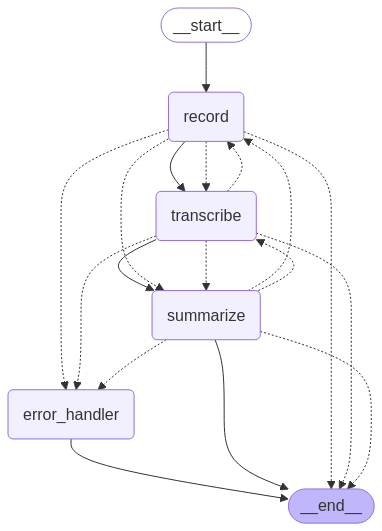

In [4]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))